## Frequency response of 2D-waveguide

In [211]:
import fenics as fen
import mshr
import helpers
import numpy as np
import matplotlib.pyplot as plt
import wg2D
import scipy.sparse
import scipy.sparse.linalg

In [212]:
def get_solution_L2_norms(omegas, K, M, L, V):
    L2_norms = np.empty(len(omegas))
    F = fen.assemble(fen.dot(fen.TrialFunction(V), fen.TestFunction(V))*fen.dx)
    for i, omega in enumerate(omegas):
        A_z = wg2D.solve(omega, K, M, L, V).vector()
        L2_norms[i] = pow((A_z*(F*A_z)).sum(), 0.5)
    return L2_norms

In [213]:
def get_analytical_resonant_frequencies(Lx, Ly, a, b):
    freqs = lambda n, m: np.pi*pow(n**2/(Lx)**2 + (m+0.5)**2/(Ly)**2 , 0.5)
    n_max = np.ceil(b * Lx / np.pi).astype('int')
    m_max = np.ceil(b * Ly / np.pi - 0.5).astype('int')
    eigs = np.unique(np.frompyfunc(freqs, 2, 1).outer(range(1, n_max+1), range(m_max+1)))
    return [e for e in eigs if a <= e and e <= b]

In [214]:
def get_numerical_eigenpairs(K, M, V, bc, a, b, k=10):
    boundary_points = bc.get_boundary_values().keys()
    all_points = V.dofmap().dofs()
    inner_points = list(set(all_points) - set(boundary_points))
    # Alternative 1: inner_points = np.where(~np.all(np.isclose(M.array(), 0), axis=1))[0]
    # Alternative 2: ones = fen.assemble(fen.TrialFunction(V)*fen.dx)
    #                ones[:] = 1
    #                bc.apply(ones)
    #                inner_points = np.array(ones.get_local(), dtype=bool)

    Mmat = fen.as_backend_type(M).mat().getValuesCSR()[::-1]
    M_sparse = scipy.sparse.csr_matrix(Mmat)
    M_reduced = M_sparse[inner_points, :][:, inner_points]
    
    Kmat = fen.as_backend_type(K).mat().getValuesCSR()[::-1]
    K_sparse = scipy.sparse.csr_matrix(Kmat)
    K_reduced = K_sparse[inner_points, :][:, inner_points]
    
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(K_reduced, k=k, M=M_reduced, sigma=(a+b)/2)

    eigvals_inside = [e1 for e1 in eigvals if a <= e1 and e1 <= b]
    eigvecs_inside = [e2 for e1, e2 in zip(eigvals, eigvecs.T) if a <= e1 and e1 <= b]
    return eigvals_inside, eigvecs_inside

In [215]:
def add_boundary_values(vec, V, bc):
    boundary_points = bc.get_boundary_values().keys()
    all_points = V.dofmap().dofs()
    inner_points = list(set(all_points) - set(boundary_points))

    full_vec = np.empty(len(all_points))
    full_vec[inner_points] = vec
    full_vec[list(boundary_points)] = list(bc.get_boundary_values().values())
    
    return full_vec

In [216]:
def plot_eigenvector(eigenvector, V, bc, reduced=True):
    if reduced:
        eigenvector = add_boundary_values(eigenvector, V, bc)
    
    coords = V.tabulate_dof_coordinates().reshape((-1, 2))
    fig, ax = plt.subplots(figsize=(6, 6*np.ptp(coords[:, 1])/np.ptp(coords[:, 0])))
    ax.margins(x=0, y=0)
    ax.tripcolor(coords[:, 0], coords[:, 1], eigenvector, shading='gouraud')

In [217]:
def eigenvector_dot_L(eigvec, V, bc, L):
    full_eigvec = add_boundary_values(eigvec, V, bc)
    return np.inner(full_eigvec, L.get_local())

### Create waveguide and set boundary conditions

In [218]:
Lx = 5.0
Ly = 1.0
domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(Lx, Ly))
mesh = mshr.generate_mesh(domain, 64)

mu = fen.Expression('1.0', degree=2) # 4*np.pi*1e-7 # magnetic permeability inside waveguide
eps = fen.Expression('1.0', degree=2) # 8.854187e-12 # electric permittivity inside waveguide
g_z_inlet = fen.Expression('1.0', degree=2)

# Define location of inlet
class Inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0) and x[1]>0 and x[1]<Ly

boundary, V, bc = wg2D.create(mesh, Inlet())

### Get stiffness and mass matrices and add forcing term

In [219]:
K, M, L = wg2D.setup(boundary, g_z_inlet, mu, eps, V, bc)

### Observe frequency response with a frequency sweep

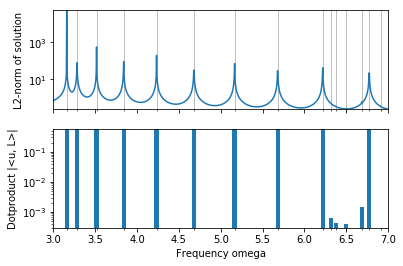

In [220]:
omegas = np.linspace(3, 7, 1000)

L2_norms =  get_solution_L2_norms(omegas, K, M, L, V)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(omegas, L2_norms)
ax[0].set_yscale('log')
ax[0].set_ylabel('L2-norm of solution')

eigvals, eigvecs = get_numerical_eigenpairs(K, M, V, bc, omegas[0]**2, omegas[-1]**2, k=50)

ax[0].vlines(np.sqrt(eigvals), 0, np.max(L2_norms), linewidth=0.5, colors='k', alpha=0.5)
ax[0].set_xticks(np.sqrt(eigvals), minor=True)
ax[0].margins(x=0, y=0)
    
dotproducts = [eigenvector_dot_L(eigvec, V, bc, L) for eigvec in eigvecs]    

ax[1].bar(np.sqrt(eigvals), np.abs(dotproducts), width=0.05)
ax[1].set_yscale('log')
ax[1].set_xlabel('Frequency omega')
ax[1].set_ylabel('Dotproduct |<u, L>|')
ax[1].set_xlim(omegas[0], omegas[-1])
ax[1].margins(y=0)
plt.show()

### Observe frequency response for an interesting region

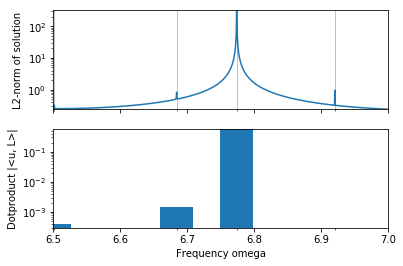

In [221]:
omegas = np.linspace(6.5, 7, 1000)

L2_norms =  get_solution_L2_norms(omegas, K, M, L, V)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(omegas, L2_norms)
ax[0].set_yscale('log')
ax[0].set_ylabel('L2-norm of solution')

eigvals, eigvecs = get_numerical_eigenpairs(K, M, V, bc, omegas[0]**2, omegas[-1]**2, k=50)

ax[0].vlines(np.sqrt(eigvals), 0, np.max(L2_norms), linewidth=0.5, colors='k', alpha=0.5)
ax[0].set_xticks(np.sqrt(eigvals), minor=True)
ax[0].margins(x=0, y=0)
    
dotproducts = [eigenvector_dot_L(eigvec, V, bc, L) for eigvec in eigvecs]    

ax[1].bar(np.sqrt(eigvals), np.abs(dotproducts), width=0.05)
ax[1].set_yscale('log')
ax[1].set_xlabel('Frequency omega')
ax[1].set_ylabel('Dotproduct |<u, L>|')
ax[1].set_xlim(omegas[0], omegas[-1])
ax[1].margins(y=0)
plt.show()

### Plot an explicitly resonant solution

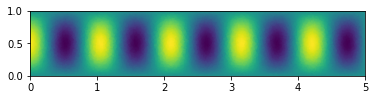

In [222]:
plot_eigenvector(eigvecs[2], V, bc)
plt.show()

### Plot a L-orthogonal resonant solution

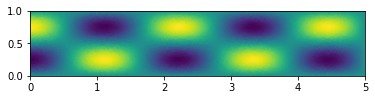

In [223]:
plot_eigenvector(eigvecs[3], V, bc)
plt.show()

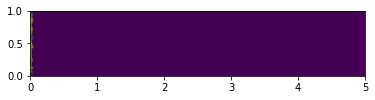

In [224]:
plot_eigenvector(L.get_local(), V, bc, reduced=False)
plt.savefig('L.png', dpi=300)

This is really interesting: Since L is everywhere zero except on the inlet (where it is constant), all eigenmodes that are symmetric at the inlet are orthogonal to L. Therefore, the solution is hindered from exploding! 

### Maybe: Try this for L originating from Gaussian?
### Move functions to helpers